 - https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
 - https://github.com/alexvlis/extractive-document-summarization

In [1]:
from rouge import Rouge
import os
from nltk import tokenize

In [2]:
import gensim
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
import nltk

Using TensorFlow backend.


In [3]:
rouge = Rouge()

In [4]:
import pandas as pd
import pickle
import sys
import warnings
warnings.filterwarnings("ignore")

### Data load for DUC Dataset.

In [5]:
def extractText(path):
    f = open(path, "r")
    fullText = f.read().replace("\n", " ")
    f.close()        
    sentences = ""
    textIndex = fullText.find("<TEXT>")

    while textIndex != -1: 
        sentences += fullText[textIndex + 6 : fullText.find("</TEXT>", textIndex) ]
        textIndex = fullText.find("<TEXT>", textIndex + 1)

    #old = sentences
    sentences = sentences.replace("<P>", " ")
    sentences = sentences.replace("</P>", " ")
    sentences = sentences.replace(";", " ")

    return tokenize.sent_tokenize(sentences)

In [6]:
def parsePerdocs(path):
    f = open(path, "r")
    
    # load all lines into a single string
    fullText = f.read().replace("\n", " ")
    f.close()
    
    # nltk attempt
    summaries = {} # { docID : summary }
    sumIndex = fullText.find("DOCREF=")
   
    # gets all of the summaries and stores them in the appropriate places 
    while sumIndex != -1:
        docID = fullText[sumIndex + 8:fullText.find("\"", sumIndex + 9)]
        
        startSum = fullText.find(">", sumIndex)
        endSum = fullText.find("</SUM>", sumIndex)

        text = fullText[startSum + 1:endSum]
        text = text.replace("<P>", " ")
        text = text.replace("</P>", " ")

        summaries[docID] = text

        sumIndex = fullText.find("DOCREF=", endSum) 
    
    for k in summaries.keys():
        summaries[k] = tokenize.sent_tokenize(summaries[k])

    return summaries

In [7]:
# Extract text and summary

dataRoot = "C:/Users/amitp/Downloads/extractive-document-summarization-master/data/DUC2001_Summarization_Documents/data/training"

Data = {}
Summaries = {}

# running count variable -- keeps track of the total size
totalSentences = 0 

# go through all of the roots of the docs
walker = os.walk(dataRoot)
for x in walker:
    path = x[0]
    dirs = x[1]
    files = x[2]
    #print(files)
    if len(dirs) == 0:
        if 'perdocs' not in files:
            for f in files:
                text = extractText(path + "/" + f)
                totalSentences += len(text)
                Data[f] = text
        else:
            summaries = parsePerdocs(path + "/perdocs")
            for k in summaries.keys():
                Summaries[k] = summaries[k]
                
#nx3output = _packageInNumpyArray(rawSummaries, rawData, rougeSaliency.saliency)

In [8]:
r_data = pd.DataFrame(Data.items(),columns=['ID','text'])
r_sumry = pd.DataFrame(Summaries.items(),columns=['ID','summaries'])
processed_data = r_data.merge(r_sumry,how = 'inner',on = 'ID')

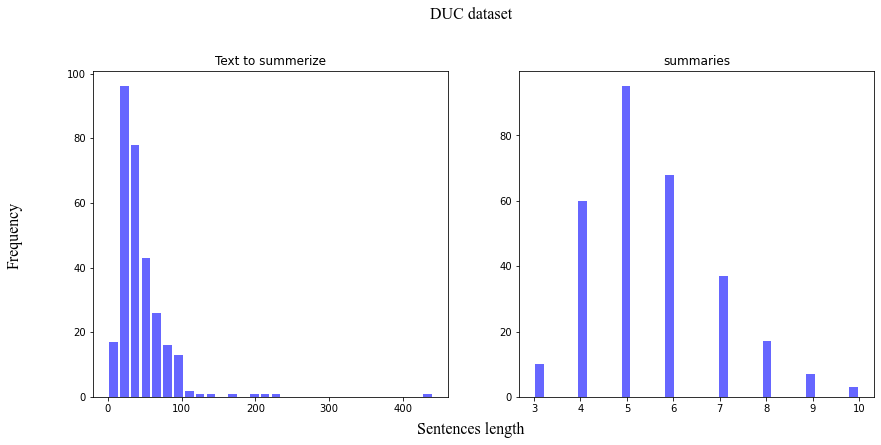

In [9]:
# check sentence length for sentence padding

sent_length = [len(i) for i in r_data.text]
#print(sent_length)
sumry_length = [len(i) for i in r_sumry.summaries]

fig = plt.figure(figsize=(14,6)) # Create matplotlib figure
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical',fontname = 'Times New Roman',fontsize = 16)
fig.text(0.5, 0.04, 'Sentences length', ha='center',fontname = 'Times New Roman',fontsize = 16)
fig.text(0.5, 1, 'DUC dataset', ha='center',fontname = 'Times New Roman',fontsize = 16)
ax = fig.add_subplot(121) # Create matplotlib axes
ax2 = fig.add_subplot(122) # Create another axes that shares the same x-axis as ax.

ax.hist(sent_length,bins = 30,color="blue", alpha = 0.6,rwidth= 0.8)
ax.set_title("Text to summerize", fontsize=12)

ax2.hist(sumry_length,bins = 30,color="blue", alpha = 0.6,rwidth= 0.8)
ax2.set_title("summaries", fontsize=12)

plt.show()


In [10]:
# total numner of sentences in text 
totalSentences = sum([len(i)for i in processed_data.text])
totalSentences

12828

In [11]:
processed_data.loc[200]

ID                                               AP900529-0104
text         [    Populist reformer Boris N. Yeltsin won th...
summaries    [  Populist reformer Boris Yeltsin won the pre...
Name: 200, dtype: object

In [12]:
# obtain the salience score for the response variable.

alpha = 0.8
cind = 0
dt_smry_score = np.zeros((totalSentences, 3), dtype=object)
for i,j in enumerate(processed_data.text):
    sentences =j
    summary = processed_data.summaries[i]
    summary = " ".join (processed_data.summaries[i])

    for s in sentences:
        dt_smry_score [cind, 0] = processed_data.ID[i]
        dt_smry_score [cind, 1] = s
        try:
            R1 = rouge.get_scores(s, summary)[0]['rouge-1']['f']
            R2 = rouge.get_scores(s, summary)[0]['rouge-2']['f']
            dt_smry_score [cind, 2] = alpha * R1 + (1 - alpha) * R2

        except:
            dt_smry_score [cind, 2] = -1
        cind = cind+1

In [13]:
dt_smry_score[:,1][0]

"     But Thomas, who has risen in Republican ranks as an advocate of bootstrap conservatism, would present a striking change from Marshall, a civil-rights pioneer and an anchor of the court's declining liberal faction."

In [14]:
sentences = dt_smry_score[:,1]
#Load Google pre-trained words 
embedding_model = gensim.models.KeyedVectors.load_word2vec_format(
    'C:/Users/amitp/Downloads/extractive-document-summarization-master/word2vec/GoogleNews-vectors-negative300.bin.gz', 
    binary=True, 
    limit=50000)


In [21]:
word_vectors = embedding_model.wv
max_sen_len = 250

#tokenize sentences
tokenizer = Tokenizer(num_words=30000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) # replace words with its wordid
padded_sequences = pad_sequences(sequences)
word_index = tokenizer.word_index
# word embedding with 300 dimensions
embedding_weights = {key: embedding_model[word] if word in word_vectors.vocab else
                              np.random.uniform(-0.25, 0.25, word_vectors.vector_size)
                        for word, key in word_index.items()}

In [23]:
embedding_weights[0] = np.zeros(word_vectors.vector_size)
#Build a 3D array: 1D fnumber of sentences, 1D for the no of words and 1D for word embedding. 
embedded_sentences = np.stack([np.stack([embedding_weights[t] for t in s]) for s in padded_sequences])


MemoryError: Unable to allocate 860. KiB for an array with shape (367, 300) and data type float64

In [ ]:
input_output = np.array([]) # data + rouge score
for i in range(len(dt_smry_score)):
    input_output = np.append(input_output,np.array([ embedded_sentences[i] , dt_smry_score[i,2] ]) )

In [ ]:
embedded_sentences.shape,len(dt_smry_score[:,2])

In [ ]:
embedded_sentences[4].shape

In [ ]:
# split embedded data into multiple files and save it.
num_parts = 8
fileName = "WordEmbeddingsToSaliency_duc"
start = 0

for i in range(num_parts):
    print("writing part,",i + 1)
    f = open(fileName + str(i + 1) + ".pickle", "wb")
    if i < num_parts - 1:
        pickle.dump(input_output[start:(i + 1) * len(input_output)//num_parts], f)
    else:
        pickle.dump(input_output[start:], f)
    f.close()
    start = (i + 1) * len(input_output)//num_parts
    print(start)